In [1]:
# http://genius.com/api-clients
client_access_token = ''

In [2]:
# Create a list of 100 greatest singers and we will download the lyrics of their songs.
one_hundred_greatest_singers = \
['Sarah Geronimo','Celine Dion','Elvis Presley','Sam Cooke','John Lennon','Marvin Gaye','Chester Charles Bennington',
 'Bob Dylan','Otis Redding','Stevie Wonder','James Brown','Paul McCartney','Little Richard','Roy Orbison',
 'Angel Armotrading','Al Green','Robert Plant','Mick Jagger','Tina Turner','Freddie Mercury','Bob Marley',
 'Smokey Robinson','Johnny Cash','Etta James','David Bowie','Van Morrison','Michael Jackson','Jackie Wilson',
 'Hank Williams','Gutu Moraganovitz','Janis Joplin','Nina Simone','Prince','Howlin Wolf','Bono','Steve Winwood',
 'Whitney Houston','Dusty Sprinfield','Bruce Springsteen','Neil Young','Elton John','Jeff Buckley','Curtis Mayfield',
 'Chuck Berry','Joni Mitchell','George Jones','Bobby Blue Bland','Kurt Cobain','Patsy Cline','Jim Morrison','Babbu Maan',
 'Donny Hathaway','Bonnie Raitt','Brian Wilson','Gladys Knight','Brian Wilson','Muddy Waters','Luther Vandross',
 'Paul Rodgers','Mavis Staples','Eric Bourdon','Christina Aguilera','Rod Stewart','Roger Daltrey','Lou Reed',
 'Axl Rose','David Ruffin','Thom Yorke','Jerry Lee Lewis','Wilson Pickett','Ronnie Spector','Gregg Allman',
 'Toots Hibbert','John Fogerty','Dolly Parton','James Taylor','Iggy Pop','Steve Perry','Frankie Valli','Mariah Carey',
 'Sly Stone','Merle Haggard','Sly Stone','Mariah Carey','Frankie Valli','John Lee Hooker','Patti Smith','Tom Waits',
 'Darlene Love','Sam Moore','Art Garfunkel','Don Henley','Willie Nelson','Solomon Burke','The Everly Brothers',
 'Levon Helm','Morrissey','Annie Lennox','Patti LaBelle','B.B. King']

In [119]:
import requests
import urllib2
import json
from bs4 import BeautifulSoup
import re
import numpy as np
import cPickle as pickle
import time
import pandas as pd

# Format a request URL for the Genius API
def process_api_request(singer):
    search_term = singer
    _URL_API = "https://api.genius.com/"
    _URL_SEARCH = "search?q="
    querystring = _URL_API + _URL_SEARCH + urllib2.quote(search_term)
    request = urllib2.Request(querystring)
    request.add_header("Authorization", "Bearer " + client_access_token)
    request.add_header("User-Agent", "")
    # Now that we’ve formatted the URL, we can make a request to the database.
    response = urllib2.urlopen(request, timeout=3)
    raw = response.read()
    json_obj = json.loads(raw)
    return json_obj

In [55]:
def get_song_info(json_obj,singer):
    music_data = []
    for obj in json_obj['response']['hits']:
        name = singer
        song = obj['result']['title']
        url = obj['result']['url']
        page = requests.get(url)    
        html = BeautifulSoup(page.text, "html.parser")
        lyrics = html.find("div", class_="lyrics").get_text().encode('ascii','ignore')
        lyrics = re.sub('\[.*\]','',lyrics) # Remove [Verse] and [Bridge] stuff
        lyrics = re.sub('\n{2}','',lyrics) # Remove gaps between verses  
        lyrics = re.sub('\\n',' ',lyrics)
        lyrics = str(lyrics).strip('\n')
        music_data.append([name,song,lyrics])
    return music_data

In [56]:
def save_data(path,data):
    # Save data to the specified file path
    with open(path,'w') as f:
        
        pickle.dump(data,f)

In [61]:
def load_data(path):
    # Load data from specified file path
    with open(path,'r') as f:
        
        data = pickle.load(f)
        
    return data

In [106]:
# Clean lyrics: Remove exessive punctuations and stopwords
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
def clean_lyric(text,stops):
    clean_text = re.sub('[^a-zA-Z]',' ',text).lower().split()
    lyric_words = [word for word in clean_text if word not in stops]
    lyric_text = ''
    for word in lyric_words:
        lyric_text+=word+' '
    
    return lyric_text

In [77]:
# Fetch data and save to local drive
path = './data/music.npy'
data=[]
i = 0
for singer in one_hundred_greatest_singers:
    json_obj = process_api_request(singer)
    data.extend(get_song_info(json_obj,singer))
    if (i+1)%10 == 0:
        save_data('./data/music{}.npy'.format(int(i/10)),data)
        data=[]
        time.sleep(60)
    print "%d percent has been processed...\r" %(i+1),
    i+=1
print'\nMission Complete...'

100 percent has been processed...
Mission Complete...


In [82]:
# Read data into memory
import glob
data = []
for part in glob.glob('./data/*.npy'):
    
    data.extend(load_data(part))

music_data = np.array(data)

In [123]:
# Remove exessive punctuations and stopwords
clean_lyrics = [clean_lyric(text,stops) for text in music_data[:,2]]
music_data[:,2]=clean_lyrics
music = pd.DataFrame(music_data,columns=['Artist','Title','Lyrics'])
music.tail(5)

,Artist,Title,Lyrics
979,B.B. King,Chains and Things,woke morning another one crazy dreams oh nothi...
980,B.B. King,Riding With The King,dreamed good job got well paid blew penny arca...
981,B.B. King,Ten Long Years,intro well woman nice kind loving every way oh...
982,B.B. King,Help The Poor,help poor help poor heart baby listen plead ne...
983,B.B. King,B.B King,bienvenue dans mon training day ok j ouvre le ...


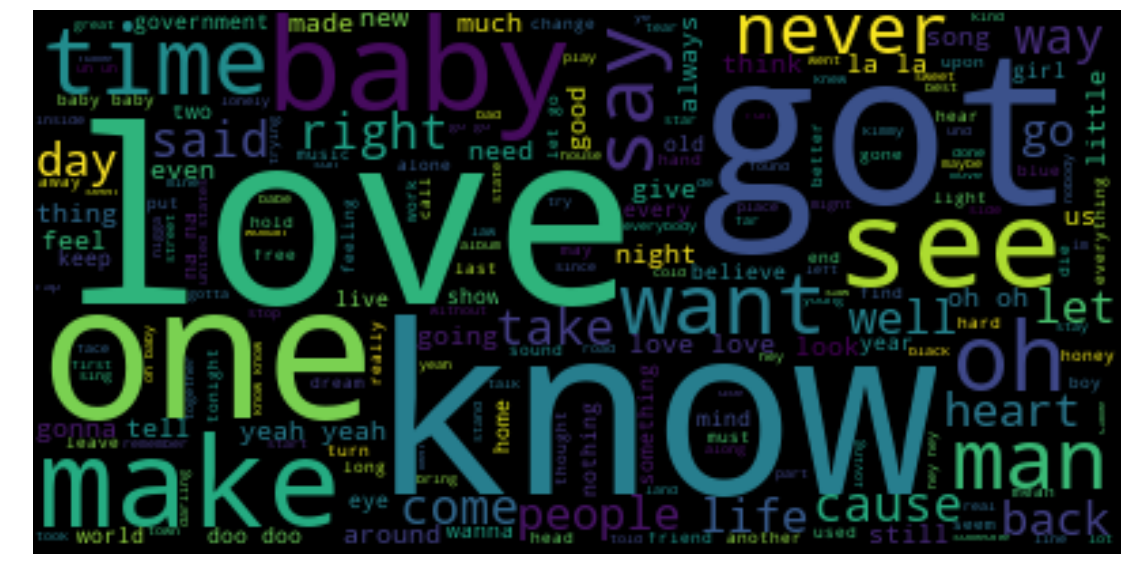

In [125]:
# Make a word cloud map reflecting word popularity
text = ''.join(music_data[:,2])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline 
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [144]:
# Create bag of words for all the lyrics
print "Creating the bag of words...\n"
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer, which is a scikitlearn's tool of bag-of-words
vectorizer = CountVectorizer(input='content',analyzer='word',tokenizer=None,\
                            vocabulary=None,max_features=5000)
bow = vectorizer.fit_transform(music['Lyrics'].values)
bow = bow.toarray()
vocab = vectorizer.get_feature_names()
vocab_tab = pd.DataFrame(bow,columns=vocab)

Creating the bag of words...



In [166]:
# Aggregate the count of words used for each artist
lyrics_bow = pd.concat([music['Artist'],vocab_tab],axis=1,join='inner')
bow_by_artist = lyrics_bow.groupby('Artist').sum()
wordy = bow_by_artist.astype(bool).sum(axis=1)
wordy = pd.DataFrame(wordy,columns=['Word Count'])
wordy = wordy.sort_values(by=['Word Count'],ascending=False)
wordy.head()

,Word Count
Artist,
Chester Charles Bennington,2964
Angel Armotrading,1497
Kurt Cobain,1119
Bob Dylan,858
Art Garfunkel,768


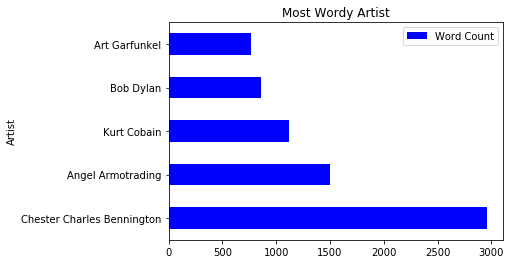

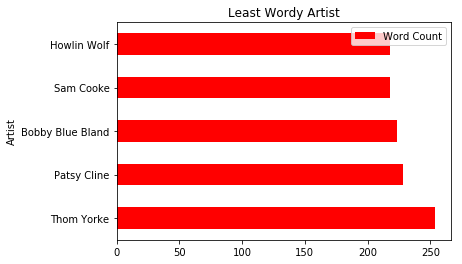

In [175]:
# Plot the top 5 Artist with most distinct words and with least ones
wordy[:5].plot.barh(color='b')
plt.title('Most Wordy Artist')
wordy[-5:].plot.barh(color='r')
plt.title('Least Wordy Artist')    